In [1]:
using BlackBoxOptim, NLsolve, Distributions, QuadGK, Plots, LaTeXStrings, LeastSquaresOptim, Roots, Base.Threads, BenchmarkTools

In [2]:
function max_return(f,set)
    optimum_auc = []
    
    if set == []
        error("the set is empty")
    else
        maximum_rev = maximum([f(set[i]) for i = 1:maximum(size(set))])
        for i in 1:maximum(size(set))
            if f(set[i]) == maximum_rev
                push!(optimum_auc, set[i])
            end
        end
    end
    return(optimum_auc, maximum_rev)
end

max_return (generic function with 1 method)

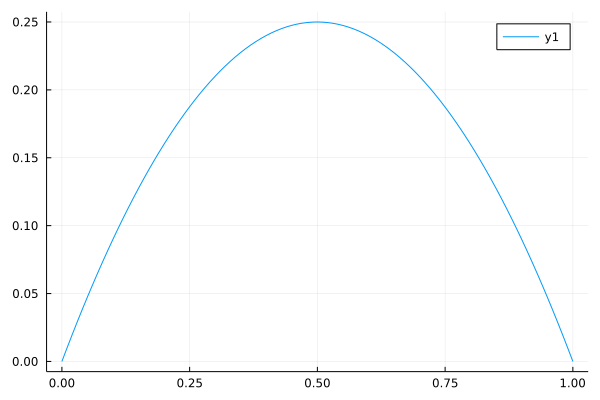

In [3]:
F(x) = cdf(Truncated(Normal(0.5,5),0,1),x)
pi(x) = x * ( 1- F(x))
plot([0:0.01:1],pi)

In [4]:
function unconstrained_auc(alpha, Fval, n)
    xi = [i for i = 0:0.01:0.99]
    Fv(x) = cdf(Fval, x)
    fv(x) = pdf(Fval,x)
    phi(x) = x - (1 - Fv(x))/fv(x)
    function pi(x)
        return  (1 - Fv(x[1])) * x[1]
    end
    #create a negative replica since the optimizer is finding the minimum. 
    pin(x) = -pi(x)
    res = bboptimize(pin ; SearchRange = (0.0 , 1.0), NumDimensions = 1);
    r_star = best_candidate(res)[1]
    
    values = [[] for _ in 1:nthreads()]
    OptimRev0 = [[] for _ in 1:nthreads()]
    OptimAucs0 = [[] for _ in 1:nthreads()]
    Threads.@threads for xi in xi
        t = max(xi, r_star)
        eqf(xi, w, t) = (1 - Fv(xi)) * phi(w) - t * (1 - Fv(t))
        eqf_a(w) = eqf(xi, w, t)
        w_hat = fzero(eqf_a,0,0.999)
        #calculate lhs
        Q_eps(alpha, w, xi, n) = ((1 - alpha)*Fv(w) + alpha * Fv(xi))^(n-1)
        Q_eps_a(w) = Q_eps(alpha, w, xi, n)
        l_value = quadgk(Q_eps_a, r_star, w_hat)[1]
        #calculate rhs
        t_adc = max(xi, r_star)
        Qeps2(xi,w,alpha)=(((1-alpha)*Fv(w)+alpha)^n - ((1-alpha)*Fv(w)+ alpha*Fv(xi))^n)/(alpha * (1-Fv(xi)))
        r_value = Qeps2(xi,w_hat,alpha)*max(w_hat - t_adc)
        auc = [r_star, max(xi,r_star), w_hat, w_hat]
        push!(values[Threads.threadid()], [xi,[l_value, r_value]])
        Qeps2(xi,v_min,v_max,alpha)=(((1-alpha)*Fv(v_max)+alpha)^n -((1-alpha)*Fv(v_min)+ alpha*Fv(xi))^n)/(n*(((1-alpha)*(Fv(v_max)-Fv(v_min))) + alpha * (1-Fv(xi))))
        Qeps3(alpha,w,n) = ((1 - alpha)*Fv(w) + alpha)^(n-1)

        function Revenue(alpha,xi,r,t,v_min,v_max) 
            #r,v_min
            rev_int(x) = Q_eps_a(x) * phi(x) * fv(x)
        
            #v_min, v_max
            rev_int2(x) = Qeps2(xi,v_min,v_max,alpha) * phi(x) * fv(x)
        
            #v_max,1
            Qeps3_a(x) = Qeps3(alpha,x,n)
            rev_int3(x) = Qeps3_a(x) * phi(x) * fv(x)
            
            return(n*(1-alpha)*(quadgk(rev_int,r,v_min)[1] + quadgk(rev_int2,v_min,v_max)[1] + quadgk(rev_int3,v_max,1)[1]) + n*alpha*Qeps2(xi,v_min,v_max,alpha)*t*(1-Fv(t)))
        end
        push!(OptimRev0[Threads.threadid()], [xi,Revenue(alpha,xi,auc[1], auc[2], auc[3], auc[4])])
        push!(OptimAucs0[Threads.threadid()], auc)
    end
    val = []
    for i in values
        append!(val, i)
    end
    values = val
    
    OptRev = []
    for i in OptimRev0
        append!(OptRev, i)
    end
    OptimRev0 = OptRev

    return(r_star, values, OptimRev0)
end
#we can confirm this works ok now

unconstrained_auc (generic function with 1 method)

In [35]:
r_star, values, OptimRev0 = unconstrained_auc(0.4,Truncated(Normal(0.5,0.5),0,1),3)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 10001 steps and 0.01 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 1150468.56
Function evals per second = 1161742.03
Improvements/step = 0.28040
Total function evaluations = 10099


Best candidate found: [0.464477]

Fitness: -0.251506004



(0.4644765584526445, Any[Any[0.0, [0.013233209802355, 0.1279498696106141]], Any[0.01, [0.013600663918694864, 0.1297630901708011]], Any[0.02, [0.013984353589987716, 0.13164906218242298]], Any[0.03, [0.014385038603067848, 0.1336109543736644]], Any[0.04, [0.014803518560758963, 0.13565210357738444]], Any[0.05, [0.015240635298608304, 0.13777602570598102]], Any[0.06, [0.015697275476295208, 0.1399864275655341]], Any[0.07, [0.01617437335874915, 0.1422872195827167]], Any[0.08, [0.01667291380348626, 0.14468252952519725]], Any[0.09, [0.01719393547230549, 0.14717671730426923]]  …  Any[0.9, [0.31740483194754787, 0.13541482655143364]], Any[0.91, [0.32475043489882727, 0.12319854077963194]], Any[0.92, [0.33213461320771004, 0.11068599323078104]], Any[0.93, [0.3395541515453911, 0.09787761106352472]], Any[0.94, [0.3470058300876314, 0.08477396094789673]], Any[0.95, [0.35448643012200404, 0.07137574626076448]], Any[0.96, [0.3619927395717855, 0.05768380409211144]], Any[0.97, [0.36952155842019396, 0.043699102

In [36]:
OptimRev0

100-element Vector{Any}:
 [0.0, 0.4496066237633433]
 [0.01, 0.45010474445015086]
 [0.02, 0.45061672022612453]
 [0.03, 0.4511428300041028]
 [0.04, 0.4516833568559916]
 [0.05, 0.45223858823613694]
 [0.06, 0.4528088162335503]
 [0.07, 0.4533943378558764]
 [0.08, 0.45399545534824143]
 [0.09, 0.4546124765503757]
 [0.1, 0.4552457152956979]
 [0.11, 0.4558954918563468]
 [0.12, 0.45656213343848334]
 ⋮
 [0.88, 0.4309384383422393]
 [0.89, 0.4260309328659963]
 [0.9, 0.42098733579682035]
 [0.91, 0.415811566278826]
 [0.92, 0.4105076875199672]
 [0.93, 0.40507989645815473]
 [0.94, 0.3995325131652711]
 [0.95, 0.3938699700319822]
 [0.96, 0.3880968007764693]
 [0.97, 0.3822176293202348]
 [0.98, 0.3762371585738888]
 [0.99, 0.3701601591753939]

In [37]:
function zeros(domain,value)
    if length(domain) != length(value)
        error("domain length must match value length")
    end
    zeros = []
    for i in 1:length(domain)-1
        #check for a change in signs 
        if (value[i] < 0 && value[i+1] > 0) |((value[i] > 0 && value[i+1] < 0)) #methods of bisection, might be able to improve accuracy by further nesting iterations 
            zero = push!(zeros,(domain[i] + domain[i+1])/2)
        #implement checks if values is just zero
        elseif (value[i] == 0) | (value[i+1] == 0)
            if value[i] == 0
                zero = push!(zeros, domain[i])
            else
                zero = push!(zeros, domain[i+1])
            end
        else
            continue
        end
    end
    return(zeros)
end

zeros (generic function with 1 method)

In [10]:
A = [[0] for _ in 1:nthreads()]
for i = 1:100
    push!(A[threadid()], [i,i^2])
end


LoadError: MethodError: [0mCannot `convert` an object of type [92mVector{Int64}[39m[0m to an object of type [91mInt64[39m
[0mClosest candidates are:
[0m  convert(::Type{T}, [91m::Base.TwicePrecision[39m) where T<:Number at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/twiceprecision.jl:262
[0m  convert(::Type{T}, [91m::AbstractChar[39m) where T<:Number at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/char.jl:185
[0m  convert(::Type{T}, [91m::CartesianIndex{1}[39m) where T<:Number at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/multidimensional.jl:136
[0m  ...

In [38]:
function constrained_auc1(alpha, F_val, n)
    
    F(x) = cdf(F_val,x)
    f(x) = pdf(F_val,x)
    
    phi(x) = x - (1 - F(x))/f(x)
    function pi(x)
        return  (1 - F(x[1])) * x[1]
    end
    #create a negative replica since the optimizer is finding the minimum. 
    pin(x) = -pi(x)
    res = bboptimize(pin ; SearchRange = (0.0 , 1.0), NumDimensions = 1);
    r_star = best_candidate(res)[1]
    
    
    
    
    makes_sense(b) = (0 < b[1] <= b[2] <= b[3] <= b[4]) # && (b[1] > r_star) && (b[2] > r_star) && (b[3] > r_star) && (b[4] )
    grid_initial_raw = [[i;j;k;l] for i = 0:0.1:1 for j = 0:0.1:1 for k = 0:0.1:1 for l = 0:0.1:1]
    grid_initial = filter((x) -> makes_sense(x),grid_initial_raw)

    OptimAucs = [Array{Any}[] for _ = 1:nthreads()]
    OptimRev1 = [Array{Any}[] for _ = 1:nthreads()]
    #for xi,best auc pairs. Aucs are calculated like in lemma 4, and we find xi2 when xi = t*. 
    @threads for xi in [i for i = 0:0.01:0.99]
        #optim auctions for given xi
        OptimAuc = []
        #the needed equations, we put it inside the loop as they changes with xi
        eq1_new(alpha,xi,t,v_min, v_max) = alpha * (pi(t) -(1-F(xi))*phi(v_max)) - (1-alpha)*((v_min-t)*((v_max - (1-F(v_max))/f(v_max))-(v_min - (1-F(v_min))/f(v_min)))* f(v_min) + (F(v_max)-F(v_min))*((v_max - (1-F(v_max))/f(v_max))-((1-F(v_min))*v_min-(1-F(v_max))*v_max)))
        phidiff(v_max,v_min) = ((v_max - (1-F(v_max))/f(v_max))-(v_min - (1-F(v_min))/f(v_min)))
        Fp(s)= F(s)^(n-1)
        eq2(alpha, t, v_min, v_max) = alpha*(-f(t)*t+(1-F(t))) + (1-alpha)*phidiff(v_max,v_min)*f(v_min)
        
        #trade probability
        Q_eps(alpha, w, xi, n) = ((1 - alpha)*F(w) + alpha * F(xi))^(n-1)
        Qeps2(xi,v_min,v_max,alpha)=(((1-alpha)*F(v_max)+alpha)^n -((1-alpha)*F(v_min)+ alpha*F(xi))^n)/(n*(((1-alpha)*(F(v_max)-F(v_min))) + alpha * (1-F(xi))))
        Qeps3(alpha,w,n) = ((1 - alpha)*F(w) + alpha)^(n-1)
        
        eq3(r,v_min,v_max)= (r - (1-F(r))/f(r))*f(r) + phidiff(v_max,v_min)*f(v_min)
        Q_eps_a(w) = Q_eps(alpha, w, xi, n)
        eq4_new(alpha,xi,r,t,v_min,v_max) = quadgk(Q_eps_a, r_star, v_min)[1] - Qeps2(xi,v_min,v_max,alpha) * max(v_min - t, 0)
        adheqvec(alpha,xi, r, t, v_min, v_max) = [eq1_new(alpha, xi, t, v_min, v_max)  eq2(alpha, t, v_min, v_max) eq3(r,v_min,v_max) eq4_new(alpha, xi, r, t, v_min, v_max)]
        adeqvec(x) = adheqvec(alpha,xi,x[1],x[2],x[3],x[4])
        
        for i in filter(x -> (x[1] != 1.0 && x[2] != 1.0 && x[3] != 1.0 && x[4] != 1.0), grid_initial)
            #trying spawn
            result = LeastSquaresOptim.optimize(adeqvec,i,Dogleg()).minimizer
            if makes_sense(result) == false
                continue
            else
                push!(OptimAuc, result)
            end
        end
        
        function Revenue(alpha,xi,r,t,v_min,v_max) 
            #r,v_min
            rev_int(x) = Q_eps_a(x) * phi(x) * f(x)
        
            #v_min, v_max
            rev_int2(x) = Qeps2(xi,v_min,v_max,alpha) * phi(x) * f(x)
        
            #v_max,1
            Qeps3_a(x) = Qeps3(alpha,x,n)
            rev_int3(x) = Qeps3_a(x) * phi(x) * f(x)
            
            return(n*(1-alpha)*(quadgk(rev_int,r,v_min)[1] + quadgk(rev_int2,v_min,v_max)[1] + quadgk(rev_int3,v_max,1)[1]) + n*alpha*Qeps2(xi,v_min,v_max,alpha)*t*(1-F(t)))
        end
        
        Revenue2(auc) = Revenue(alpha,xi,auc[1], auc[2], auc[3], auc[4])
        bestauc,bestrev = max_return(Revenue2,OptimAuc)
        
        #test
        #println("thread is ",threadid())
        #print(OptimAuc)
        #println(max_return(Revenue2,OptimAuc))

        #println("before.     ",threadid(),"  ", typeof(OptimRev1),typeof([xi,bestrev]))
        #println(OptimRev1)
        #add the results
        push!(OptimAucs[threadid()],[xi,bestauc])
        push!(OptimRev1[Threads.threadid()], [xi,bestrev])
        #test
        #println(threadid(),".   ", OptimRev1)
        #from by-thread stored results to regular 
        #OptAc = []
        #for i in OptimAucs
        #    append!(OptAc, i)
        #end
        #OptimAucs = OptAc
        
        #OptRev = []
        #for i in OptimRev1
        #    append!(OptRev, i)
        #end
        #OptimRev1 = OptRev
        
        #test
    
        
        #sort in the order of xi
        #OptimAucs = sort!(OptimAucs, by = x -> x[1])
        #OptimRev1 = sort!(OptimRev1,by = x -> x[1])  
    end
    
    OptAc = []
    for i in OptimAucs
        append!(OptAc, i)
    end
    OptimAucs = OptAc
    
    OptRev = []
    for i in OptimRev1
        append!(OptRev, i)
    end
    OptimRev1 = OptRev
    
    return(OptimAucs, OptimRev1)
end

    

constrained_auc1 (generic function with 1 method)

In [39]:
OptimAucs, OptimRev1 = constrained_auc1(0.4,Truncated(Normal(0.5,0.5),0,1),3)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 10001 steps and 0.01 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 1503646.78
Function evals per second = 1519132.80
Improvements/step = 0.28270
Total function evaluations = 10104


Best candidate found: [0.464477]

Fitness: -0.251506004



(Any[Any[0.0, Any[[0.42901653040007237, 0.5194880582589669, 0.5425681163557604, 0.5813900401684005], [0.4290165304000724, 0.5194880582589668, 0.5425681163557604, 0.5813900401684005], [0.4290165304000725, 0.5194880582589668, 0.5425681163557604, 0.5813900401684005], [0.4290165304000724, 0.5194880582589669, 0.5425681163557604, 0.5813900401684005], [0.4290165304000725, 0.5194880582589668, 0.5425681163557604, 0.5813900401684005], [0.4290165304000724, 0.5194880582589669, 0.5425681163557605, 0.5813900401684005], [0.42901653040007254, 0.5194880582589669, 0.5425681163557604, 0.5813900401684005], [0.4290165304000724, 0.519488058258967, 0.5425681163557604, 0.5813900401684005], [0.4290165304000725, 0.5194880582589668, 0.5425681163557604, 0.5813900401684005], [0.4290165304000725, 0.5194880582589669, 0.5425681163557605, 0.5813900401684005], [0.42901653040007237, 0.5194880582589669, 0.5425681163557604, 0.5813900401684005], [0.4290165304000723, 0.519488058258967, 0.5425681163557604, 0.5813900401684005

LoadError: UndefVarError: OptimAucs not defined

In [52]:
a = [[[1.0,1.0]] for i in 1:nthreads()]
push!(a[threadid()],[2.0,2.0])


2-element Vector{Vector{Float64}}:
 [1.0, 1.0]
 [2.0, 2.0]

In [40]:
initial_grid = 

Vector{Vector{Any}} (alias for Array{Array{Any, 1}, 1})

In [40]:
xi1 = zeros([i[1] for i in OptimAucs], [i[2][1][2] - i[1] for i in OptimAucs])[1]

0.535

In [41]:
values

100-element Vector{Any}:
 Any[0.0, [0.013233209802355, 0.1279498696106141]]
 Any[0.01, [0.013600663918694864, 0.1297630901708011]]
 Any[0.02, [0.013984353589987716, 0.13164906218242298]]
 Any[0.03, [0.014385038603067848, 0.1336109543736644]]
 Any[0.04, [0.014803518560758963, 0.13565210357738444]]
 Any[0.05, [0.015240635298608304, 0.13777602570598102]]
 Any[0.06, [0.015697275476295208, 0.1399864275655341]]
 Any[0.07, [0.01617437335874915, 0.1422872195827167]]
 Any[0.08, [0.01667291380348626, 0.14468252952519725]]
 Any[0.09, [0.01719393547230549, 0.14717671730426923]]
 Any[0.1, [0.01773853428729609, 0.14977439095734332]]
 Any[0.11, [0.018307867153114225, 0.15248042391778405]]
 Any[0.12, [0.018903155969716697, 0.15529997369053727]]
 ⋮
 Any[0.88, [0.30284215686477106, 0.15895761711580222]]
 Any[0.89, [0.3101010095135586, 0.1473345655050662]]
 Any[0.9, [0.31740483194754787, 0.13541482655143364]]
 Any[0.91, [0.32475043489882727, 0.12319854077963194]]
 Any[0.92, [0.33213461320771004, 0.110685

In [42]:
xi2 = zeros([i[1] for i in values], [i[2][1] - i[2][2] for i in values])[1]

0.795

In [43]:
function constrained_aucs2(alpha, F_val, n, xi1, xi2)
    F(x) = cdf(F_val, x)
    f(x) = pdf(F_val, x)
    phi(x) = x - (1 - F(x))/f(x)

    function pi(x)
        return  (1 - F(x[1])) * x[1]
    end
    #create a negative replica since the optimizer is finding the minimum. 
    pin(x) = -pi(x)
    res = bboptimize(pin ; SearchRange = (0.0 , 1.0), NumDimensions = 1);
    r_star = best_candidate(res)[1]
  
    
    
    OptimAucs2 = []
    OptimRev2 = []
    makes_sense(b) = (0 < b[1] <= b[2] <= b[3]) # && (b[1] > r_star) && (b[2] > r_star) && (b[3] > r_star) && (b[4] )
    grid_initial_raw = [[i;j;k] for i = 0:0.01:1 for j = 0:0.1:1 for k = 0:0.01:1 ]
    grid_initial = filter((x) -> makes_sense(x),grid_initial_raw)
    
    @threads for xi in [i for i = 0:0.01:1 if xi1 < i < xi2]
        #TEST print xi
        OptimAuc = []
        eq1_new(alpha,xi,t,v_min, v_max) = alpha * (t*(1-F(t))-(1-F(xi))*phi(v_max)) - (1-alpha)*((v_min-t)*((v_max - (1-F(v_max))/f(v_max))-(v_min - (1-F(v_min))/f(v_min)))* f(v_min) + (F(v_max)-F(v_min))*((v_max - (1-F(v_max))/f(v_max))-((1-F(v_min))*v_min-(1-F(v_max))*v_max)))
        phidiff(v_max,v_min) = ((v_max - (1-F(v_max))/f(v_max))-(v_min - (1-F(v_min))/f(v_min)))
        Fp(s)= F(s)^(n-1)
        eq2(alpha, t, v_min, v_max) = -alpha*(-f(t)*t+(1-F(t))) - (1-alpha)*phidiff(v_max,v_min)*f(v_min)
        Q_eps(alpha, w, xi, n) = ((1 - alpha)*F(w) + alpha * F(xi))^(n-1)
        Qeps2(xi,v_min,v_max,alpha)=(((1-alpha)*F(v_max)+alpha)^n -((1-alpha)*F(v_min)+ alpha*F(xi))^n)/(n*(((1-alpha)*(F(v_max)-F(v_min))) + alpha * (1-F(xi))))
        Qeps3(alpha,w,n) = ((1 - alpha)*F(w) + alpha)^(n-1)

        eq3(r,v_min,v_max)= -(r - (1-F(r))/f(r))*f(r) - phidiff(v_max,v_min)*f(v_min)
        Q_eps_a(w) = Q_eps(alpha, w, xi, n)
        eq4_new(alpha,xi,r,t,v_min,v_max) = quadgk(Q_eps_a, r_star, v_min)[1] - Qeps2(xi,v_min,v_max,alpha) * max(v_min - t, 0)
        adheqvec(alpha,xi, r, t, v_min, v_max) = [eq1_new(alpha, xi, t, v_min, v_max)  eq2(alpha, t, v_min, v_max) eq3(r,v_min,v_max) eq4_new(alpha, xi, r, t, v_min, v_max)]
        adeqvec2(x) = adheqvec(alpha,xi,x[1],xi,x[2],x[3])
        
        #for large xis, if xi2 is big then the sanity check would take out all results due to limitation of the refinement of the initial grid
        lk = ReentrantLock()
        lock(lk) do 
            for i in filter(x -> (x[1] != 1.0 && x[2] != 1.0 && x[3] != 1.0), [[i[1],i[2],i[3]] for i in grid_initial])
                result = LeastSquaresOptim.optimize(adeqvec2,i,Dogleg()).minimizer
                if (result[1] <= xi <= result[2] <= result[3]) == false
                    continue
                else
                    push!(OptimAuc, result)
                    #testing 
                    #println([xi,threadid()])
                end
            end
        end
        
        
        #TEST: optimauc
        if isempty(OptimAuc)
            print(xi)
            continue
        end
        
        
        function Revenue(alpha,xi,r,t,v_min,v_max) 
            #r,v_min
            rev_int(x) = Q_eps_a(x) * phi(x) * f(x)
        
            #v_min, v_max
            rev_int2(x) = Qeps2(xi,v_min,v_max,alpha) * phi(x) * f(x)
        
            #v_max,1
            Qeps3_a(x) = Qeps3(alpha,x,n)
            rev_int3(x) = Qeps3_a(x) * phi(x) * f(x)
            
            return(n*(1-alpha)*(quadgk(rev_int,r,v_min)[1] + quadgk(rev_int2,v_min,v_max)[1] + quadgk(rev_int3,v_max,1)[1]) + n*alpha*Qeps2(xi,v_min,v_max,alpha)*t*(1-F(t)))
        end
        Revenue2(auc) = Revenue(alpha,xi,auc[1], xi, auc[2], auc[3])
        bestauc,bestrev = max_return(Revenue2,OptimAuc)
        push!(OptimAucs2,[xi,[bestauc[1][1],xi,bestauc[1][2],bestauc[1][3]]])#xi, auction pairs   
        push!(OptimRev2,[xi, bestrev])
        OptimRev2 = sort!(OptimRev2, by = x -> x[1])
    end
    return(OptimAucs2, OptimRev2)

end


constrained_aucs2 (generic function with 1 method)

In [45]:
OptimAucs2, OptimRev2 = constrained_aucs2(0.4, Truncated(Normal(0.5,5),0,1),3,xi1,xi2)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 10001 steps and 0.01 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 1090019.86
Function evals per second = 1096559.33
Improvements/step = 0.21310
Total function evaluations = 10061


Best candidate found: [0.499584]

Fitness: -0.250000173

0.740.720.70.680.730.710.69

(Any[Any[0.56, [0.4580127410214825, 0.56, 0.6823005005549654, 0.7239572206471839]], Any[0.75, [0.5, 0.75, 0.9, 0.9000000000000001]], Any[0.58, [0.4474610632510819, 0.58, 0.6848182362233243, 0.7370519746299501]], Any[0.76, [0.5, 0.76, 0.9, 0.9]], Any[0.77, [0.49, 0.77, 0.9, 0.9000000000000001]], Any[0.78, [0.5, 0.78, 0.9, 0.91]], Any[0.79, [0.5, 0.79, 0.9, 0.9100000000000001]], Any[0.64, [0.4135925109224926, 0.64, 0.6842929769129183, 0.7704772017143325]], Any[0.62, [0.42532005319112587, 0.62, 0.6862001490313937, 0.7606290513088394]], Any[0.54, [0.4682951567821284, 0.54, 0.6789596281824369, 0.7103102285037267]], Any[0.66, [0.40133601975568967, 0.66, 0.680051099563046, 0.7785190870724922]], Any[0.6, [0.43658540079815983, 0.6, 0.686234874410321, 0.7493709205412754]], Any[0.57, [0.4527737115116512, 0.57, 0.6836780353806825, 0.7305862692801643]], Any[0.59, [0.4420675951306287, 0.59, 0.6856842998123104, 0.7433246904617979]], Any[0.55, [0.46318462963670953, 0.55, 0.6807181561984184, 0.71719091

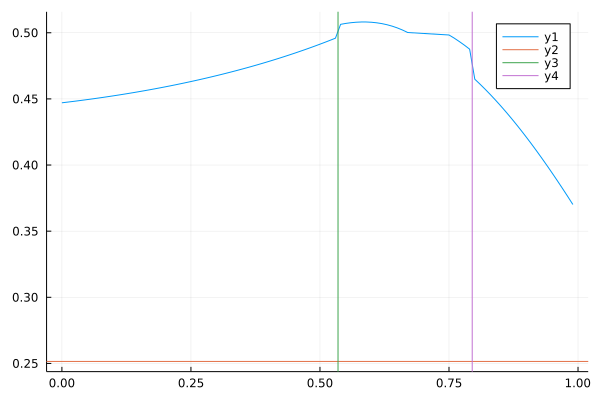

In [46]:
plot(union([i[1] for i in OptimRev1 if i[1] <= xi1],[i[1] for i in OptimRev2],[i[1] for i in OptimRev0 if i[1] > xi2]), union([i[2] for i in OptimRev1 if i[1]<=xi1],[i[2] for i in OptimRev2],[i[2] for i in OptimRev0 if i[1] > xi2]))
#plot!([i[1] for i in OptimRev2], [i[2] for i in OptimRev2])
#plot!([i[1] for i in OptimRev0 if i[1] > xi2], [i[2] for i in OptimRev0 if i[1] > xi2], legend = :bottomright)
hline!([r_star * (1 - cdf(Truncated(Normal(0.5,0.5),0,1),r_star))])
vline!([xi1])
vline!([xi2])

Do not run the code under this line yet.

In [ ]:
[i for i = 0:0.01:1 if xi1 < i < xi2]

In [ ]:
for i in OptimRev1
    println(i)
end

In [ ]:
r_star, values, OptimRev0 = unconstrained_auc(0.8,Truncated(Normal(0.5,0.15),0,1),20)

In [ ]:
OptimAucs, OptimRev1 = constrained_auc1(0.8,Truncated(Normal(0.5,0.15),0,1),20)

In [ ]:
xi1 = zeros([i[1] for i in OptimAucs], [i[2][1][2] - i[1] for i in OptimAucs])[1]


In [ ]:
xi2 = zeros([i[1] for i in values], [i[2][1] - i[2][2] for i in values])[1]

In [ ]:
OptimAucs2, OptimRev2 = constrained_aucs2(0.8, Truncated(Normal(0.5,0.15),0,1),20,xi1,xi2)

In [ ]:
plot([i[1] for i in OptimRev1 if i[1] <= xi1 ], [i[2] for i in OptimRev1 if i[1]<=xi1])
plot!([i[1] for i in OptimRev2], [i[2] for i in OptimRev2])
plot!([i[1] for i in OptimRev0 if i[1] > xi2], [i[2] for i in OptimRev0 if i[1] > xi2])
hline!([r_star * (1 - cdf(Truncated(Normal(0.5,0.15),0,1),r_star))])

In [36]:
lk = ReentrantLock() 
lock(lk) do 
end


In [ ]:
a = []

@threads for i = 1:100
    lock(lk)
    a = a .+ i 
    unlock(lk)
end


LoadError: syntax: unexpected "="